In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

class MoannaDataset(Dataset):
    def __init__(self, data_file, label_file):
        self.data = pd.read_csv(data_file, sep=',', header=0, index_col=0).values
        self.label = pd.read_csv(label_file, header=0, index_col=0).values[:,1]
        self.data = torch.from_numpy(self.data).float().to(device)
        self.label = self.label.astype(int)
        self.label = torch.from_numpy(self.label).long().to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


class MoannaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MoannaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [3]:

data_file = '/home/intern/WarmUpProject/p-tcga_binary_mutation.csv'
label_file = '/home/intern/WarmUpProject/pp-TCGA-clinical.csv'

dataset = MoannaDataset(data_file, label_file)

batch_size = 64


In [4]:
idx = torch.randperm(len(dataset))

split_point = int(0.7 * len(idx))

train_idx = idx[:split_point]
test_idx = idx[split_point:]

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 


In [5]:
train_dataset.dataset.label

tensor([ 7,  7,  7,  ..., 28,  3,  2], device='cuda:0')

In [6]:
def k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, device, shuffle=True):
    
    n_samples = len(train_dataset)
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)

    Model = []
    
    for i in range(k):
        print(f"Processing fold {i+1}/{k}...")
        
        start = i * fold_size
        end = (i + 1) * fold_size
        
        traintrain_indices = np.concatenate([indices[:start], indices[end:]])
        trainval_indices = indices[start:end]
        
        # Create data loaders for training and validation
        traintrain_dataset = Subset(train_dataset, traintrain_indices)
        trainval_dataset = Subset(train_dataset, trainval_indices)
        traintrain_loader = DataLoader(traintrain_dataset, batch_size=batch_size, shuffle=shuffle)
        trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=False)    
        
        # Hyperparameters
        learning_rate = 0.1
        hidden_dim = 128

        # Initialize model and transfer to GPU
        model = MoannaModel(train_dataset.data.shape[1], hidden_dim, 33).to(device)
        

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Train the model
        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []
        for epoch in range(num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for j, (inputs, labels) in enumerate(traintrain_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

            train_loss /= len(traintrain_loader)
            train_acc /= len(traintrain_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validate
            model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for inputs, labels in trainval_loader:
                    outputs = model(inputs)
                    val_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                val_acc /= len(trainval_loader)
                val_accs.append(val_acc)

            # # Check if this is the best model so far
            # if val_acc > best_accuracy:
            #     best_accuracy = val_acc
            #     best_model = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
            #     best_model.load_state_dict(model.state_dict())
                
            # Test
            model.eval()
            test_acc = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                test_acc /= len(test_loader)
                test_accs.append(test_acc)
                
            print(f"Fold {i+1}/{k}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")
            
        MModel = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
        MModel.load_state_dict(model.state_dict())
        Model.append(MModel)
        
        # Plot loss and accuracy for this fold
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.legend()
        plt.title(f"Fold {i+1} Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.legend()
        plt.title(f"Fold {i+1} Accuracy")
        plt.show()

    return Model

Processing fold 1/5...
Fold 1/5, Epoch 1: Train Loss=3.3123, Train Acc=0.1260, Val Acc=0.1842, Test Acc=0.1926
Fold 1/5, Epoch 2: Train Loss=3.0366, Train Acc=0.1792, Val Acc=0.2292, Test Acc=0.2596
Fold 1/5, Epoch 3: Train Loss=2.8055, Train Acc=0.2498, Val Acc=0.2967, Test Acc=0.3390
Fold 1/5, Epoch 4: Train Loss=2.5670, Train Acc=0.3252, Val Acc=0.3151, Test Acc=0.3644
Fold 1/5, Epoch 5: Train Loss=2.3551, Train Acc=0.3814, Val Acc=0.3507, Test Acc=0.4340
Fold 1/5, Epoch 6: Train Loss=2.1653, Train Acc=0.4446, Val Acc=0.3979, Test Acc=0.5008
Fold 1/5, Epoch 7: Train Loss=2.0156, Train Acc=0.4990, Val Acc=0.4118, Test Acc=0.5392
Fold 1/5, Epoch 8: Train Loss=1.8646, Train Acc=0.5401, Val Acc=0.4303, Test Acc=0.5773
Fold 1/5, Epoch 9: Train Loss=1.7415, Train Acc=0.5745, Val Acc=0.4367, Test Acc=0.6108
Fold 1/5, Epoch 10: Train Loss=1.6122, Train Acc=0.6106, Val Acc=0.4404, Test Acc=0.6339
Fold 1/5, Epoch 11: Train Loss=1.4968, Train Acc=0.6413, Val Acc=0.4489, Test Acc=0.6687
Fold 1/

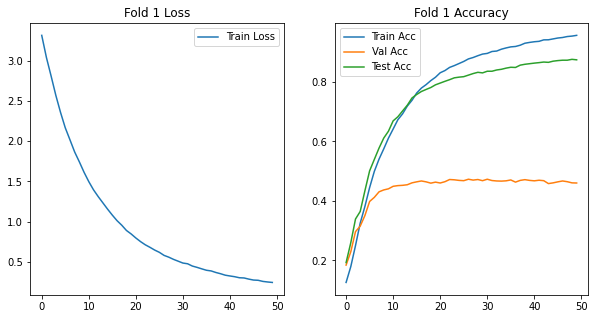

Processing fold 2/5...
Fold 2/5, Epoch 1: Train Loss=3.3298, Train Acc=0.1250, Val Acc=0.1672, Test Acc=0.1776
Fold 2/5, Epoch 2: Train Loss=3.0379, Train Acc=0.1799, Val Acc=0.1740, Test Acc=0.1981
Fold 2/5, Epoch 3: Train Loss=2.7999, Train Acc=0.2441, Val Acc=0.2744, Test Acc=0.3257
Fold 2/5, Epoch 4: Train Loss=2.5700, Train Acc=0.3201, Val Acc=0.3016, Test Acc=0.3569
Fold 2/5, Epoch 5: Train Loss=2.3468, Train Acc=0.3817, Val Acc=0.3455, Test Acc=0.4275
Fold 2/5, Epoch 6: Train Loss=2.1660, Train Acc=0.4501, Val Acc=0.3854, Test Acc=0.4959
Fold 2/5, Epoch 7: Train Loss=2.0033, Train Acc=0.5004, Val Acc=0.4020, Test Acc=0.5291
Fold 2/5, Epoch 8: Train Loss=1.8567, Train Acc=0.5353, Val Acc=0.4150, Test Acc=0.5604
Fold 2/5, Epoch 9: Train Loss=1.7236, Train Acc=0.5791, Val Acc=0.4336, Test Acc=0.6014
Fold 2/5, Epoch 10: Train Loss=1.5991, Train Acc=0.6139, Val Acc=0.4373, Test Acc=0.6385
Fold 2/5, Epoch 11: Train Loss=1.4958, Train Acc=0.6491, Val Acc=0.4398, Test Acc=0.6501
Fold 2/

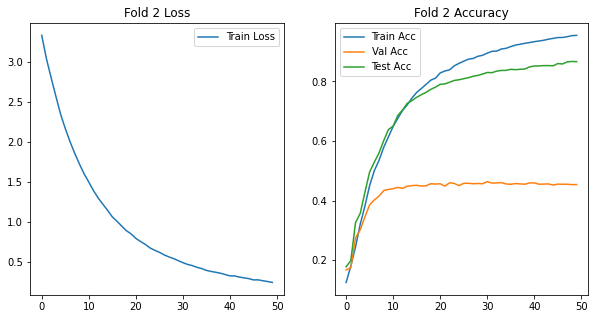

Processing fold 3/5...
Fold 3/5, Epoch 1: Train Loss=3.3167, Train Acc=0.1270, Val Acc=0.1659, Test Acc=0.1838
Fold 3/5, Epoch 2: Train Loss=3.0432, Train Acc=0.1781, Val Acc=0.2065, Test Acc=0.2245
Fold 3/5, Epoch 3: Train Loss=2.8023, Train Acc=0.2441, Val Acc=0.2708, Test Acc=0.3257
Fold 3/5, Epoch 4: Train Loss=2.5731, Train Acc=0.3164, Val Acc=0.3045, Test Acc=0.3595
Fold 3/5, Epoch 5: Train Loss=2.3490, Train Acc=0.3729, Val Acc=0.3613, Test Acc=0.4464
Fold 3/5, Epoch 6: Train Loss=2.1689, Train Acc=0.4423, Val Acc=0.3833, Test Acc=0.4852
Fold 3/5, Epoch 7: Train Loss=2.0063, Train Acc=0.4955, Val Acc=0.4072, Test Acc=0.5418
Fold 3/5, Epoch 8: Train Loss=1.8569, Train Acc=0.5396, Val Acc=0.4333, Test Acc=0.5893
Fold 3/5, Epoch 9: Train Loss=1.7280, Train Acc=0.5781, Val Acc=0.4313, Test Acc=0.6219
Fold 3/5, Epoch 10: Train Loss=1.6054, Train Acc=0.6095, Val Acc=0.4364, Test Acc=0.6401
Fold 3/5, Epoch 11: Train Loss=1.4998, Train Acc=0.6400, Val Acc=0.4393, Test Acc=0.6745
Fold 3/

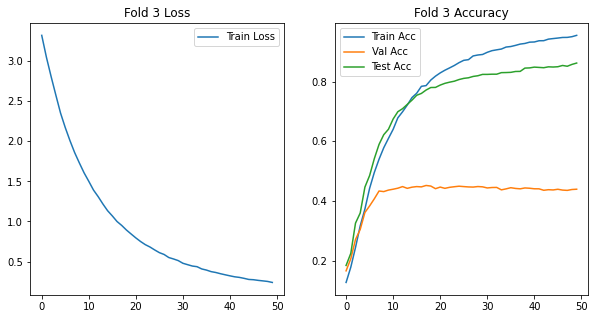

Processing fold 4/5...
Fold 4/5, Epoch 1: Train Loss=3.3172, Train Acc=0.1177, Val Acc=0.1940, Test Acc=0.2115
Fold 4/5, Epoch 2: Train Loss=3.0263, Train Acc=0.1835, Val Acc=0.2004, Test Acc=0.2238
Fold 4/5, Epoch 3: Train Loss=2.7892, Train Acc=0.2531, Val Acc=0.2780, Test Acc=0.3263
Fold 4/5, Epoch 4: Train Loss=2.5511, Train Acc=0.3276, Val Acc=0.3037, Test Acc=0.3774
Fold 4/5, Epoch 5: Train Loss=2.3338, Train Acc=0.4013, Val Acc=0.3610, Test Acc=0.4591
Fold 4/5, Epoch 6: Train Loss=2.1457, Train Acc=0.4607, Val Acc=0.3973, Test Acc=0.5298
Fold 4/5, Epoch 7: Train Loss=1.9943, Train Acc=0.5064, Val Acc=0.4027, Test Acc=0.5467
Fold 4/5, Epoch 8: Train Loss=1.8457, Train Acc=0.5419, Val Acc=0.4173, Test Acc=0.5893
Fold 4/5, Epoch 9: Train Loss=1.7118, Train Acc=0.5855, Val Acc=0.4333, Test Acc=0.6199
Fold 4/5, Epoch 10: Train Loss=1.5848, Train Acc=0.6201, Val Acc=0.4308, Test Acc=0.6401
Fold 4/5, Epoch 11: Train Loss=1.4778, Train Acc=0.6491, Val Acc=0.4403, Test Acc=0.6639
Fold 4/

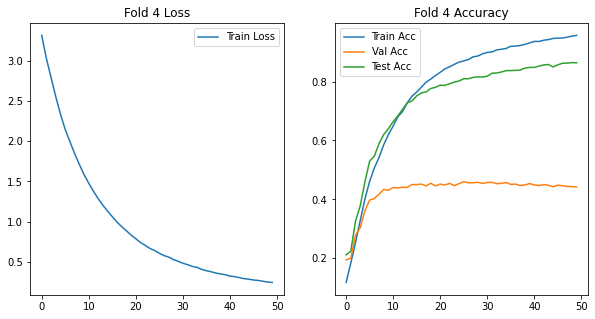

Processing fold 5/5...
Fold 5/5, Epoch 1: Train Loss=3.3090, Train Acc=0.1191, Val Acc=0.1403, Test Acc=0.1545
Fold 5/5, Epoch 2: Train Loss=3.0338, Train Acc=0.1775, Val Acc=0.1782, Test Acc=0.2049
Fold 5/5, Epoch 3: Train Loss=2.8025, Train Acc=0.2424, Val Acc=0.2811, Test Acc=0.3305
Fold 5/5, Epoch 4: Train Loss=2.5691, Train Acc=0.3160, Val Acc=0.3071, Test Acc=0.3615
Fold 5/5, Epoch 5: Train Loss=2.3509, Train Acc=0.3744, Val Acc=0.3390, Test Acc=0.4135
Fold 5/5, Epoch 6: Train Loss=2.1665, Train Acc=0.4440, Val Acc=0.4048, Test Acc=0.5060
Fold 5/5, Epoch 7: Train Loss=1.9985, Train Acc=0.4940, Val Acc=0.4181, Test Acc=0.5415
Fold 5/5, Epoch 8: Train Loss=1.8540, Train Acc=0.5352, Val Acc=0.4425, Test Acc=0.5854
Fold 5/5, Epoch 9: Train Loss=1.7182, Train Acc=0.5784, Val Acc=0.4499, Test Acc=0.6163
Fold 5/5, Epoch 10: Train Loss=1.6052, Train Acc=0.6140, Val Acc=0.4518, Test Acc=0.6346
Fold 5/5, Epoch 11: Train Loss=1.4952, Train Acc=0.6399, Val Acc=0.4655, Test Acc=0.6717
Fold 5/

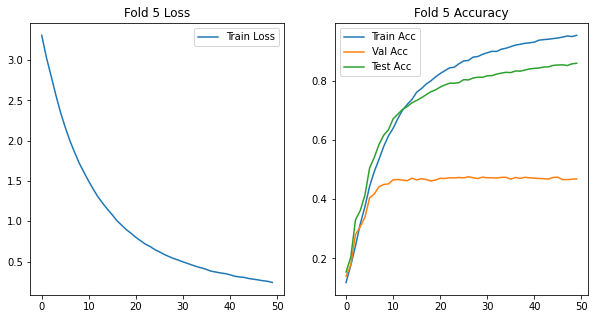

In [7]:
num_epochs = 50
k = 5

Model = k_fold_cross_validation(train_dataset.dataset, test_loader, k, num_epochs, batch_size, device=device, shuffle=True)

In [8]:
Model

[MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=12

In [9]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

        test_acc /= len(test_loader)

    print(f"Test Accuracy: {test_acc:.4f}")

In [10]:
for i in range(5):
    test_model(Model[i], test_loader)

Test Accuracy: 0.8737
Test Accuracy: 0.8665
Test Accuracy: 0.8620
Test Accuracy: 0.8636
Test Accuracy: 0.8591


In [11]:


for inputs, labels in train_loader:
    outputs = Model[1](inputs)
    print(torch.argmax(outputs, dim=1))
    print(labels)

tensor([21, 29, 12, 27, 27, 31, 15, 14, 18, 15,  0, 15, 24, 20,  1, 16,  1, 29,
        14,  1,  0,  0, 24,  1,  8, 11,  8, 15,  2,  1, 11, 21,  4, 11,  8, 11,
        21, 13,  1, 18,  1,  1, 10, 14, 24, 13, 11, 16, 21, 24,  8,  1,  4, 24,
        14, 27, 27, 27,  7,  1, 21, 23, 29,  4], device='cuda:0')
tensor([ 1, 29, 12,  0, 20, 31, 15, 14, 18, 15,  0, 15, 24, 26, 14, 16,  1, 29,
        14,  1,  0,  0, 24,  1,  8, 11,  8, 15,  2,  1, 11, 21,  4, 11,  0, 11,
        21, 13,  1, 18, 21,  1, 10, 14, 24, 13, 11, 16,  2, 24,  8,  1,  4, 24,
        14, 20, 27, 17, 29,  1,  1, 14, 29,  4], device='cuda:0')
tensor([ 4,  7, 29,  7, 27,  8, 21, 16, 18, 27, 13, 20, 14,  0, 14, 16,  4, 15,
        23, 20,  1, 16, 29, 25,  8,  2, 13, 16, 31, 27,  8,  5, 10,  7,  1, 18,
        21,  1, 24, 29, 21, 23,  4, 13, 29, 21, 27, 27, 16, 22, 21,  1, 21, 25,
         1,  2, 16,  4, 27, 21, 18, 29,  1, 16], device='cuda:0')
tensor([22,  7, 30, 13, 27,  8, 21, 16, 16, 12, 13, 32, 14,  0, 14, 16,  4, 15,
  